# A comparison between MNE-Python's RAP-MUSIC and Alternating Projections (AP) 
### Simulating 2 sources, varying in SNR and Signal Correlation

[MNE-Python](http://mne.tools/stable/index.html) offers a verity of multiple dipole localization methods for evoked EEG/MEG data.<br>
Of those, we are going to compare the preformance of 2 beamformer methods - [RAP MUSIC](https://mne.tools/stable/generated/mne.beamformer.rap_music.html#mne.beamformer.rap_music) and AP as currently implemented in the MNE-Python package.<br> The functions will be set to find 2 active sources, simulated with varying SNR and signal correlation (between the two signals simulated) across different samples, using the evoked time-series given by the forward model (built with MNE-Python).<br> The results will be partially visualized across 2 section addressing 2 modes of modeling - [freely oriented dipoles model](#Freely-oriented-dipoles-model) and [fixed oriented dipoles model](#Fixed-oriented-dipoles-model).<br><br>About **the metrics** used:<br>-**Distance**: the average distance between the estimated active dipole and the simulated active dipole.<br>-**Orientation correlation**: the correlation between the estimated orientation assign to each estimated dipole and the true orientation of the simulated dipoles (only relevant for the freely oriented case).<br>-**Relative Tolerance**: given an estimation on the dipoles localization (and orientation) an updated gain can be computed considering the contribution of the estimated dipoles alone. Substracting the evoked data projected by the updated gain from the original evoked data gives the evoked data that couldn't be explained with the dipoles chosen, namely, the residual. The relative tolarence is the Frobenius norm of the residual divided by the Frobenius norm of the simulated evoked data.<br><br>About **the simulation**:<br>Given a forward model localizing a set of dipoles, 2 are randomly chosen, one from each lobe, for each sample. using an mne.Evoked object, provided by the MNE-Python data folders, we produce 2 time series of dipole activation, modeled as cosines, correlated to a chosen extent. Noise is added using the noise covariance matrix given by MNE-Python's data folders. Then the simulated data amplitude is calibrated to a target SNR. The entire process can be reproduced following the code in the [reproducing simulation data](#Reproducing-simulation-data) section. Readily available data sets with simulation results are featured on current folder ("**APvRAP_fixed.h5**" and "**APvRAP_free.h5**") containing the following:<br>-**SNR** = [-15,-10,-5,0,5,10,15].<br>-**Inter-source correlation** = [0.5,0.7,0.85,0.9,0.95,1].<br>-**No. of samples**: ~550 of each (SNR,Sig. Corr.) combination for each Algorithmic method tested.<br><br>**Note**:<br>most of the functions used for simulation and visualization are contained inside aux_func.py .<br> MNE-Python package is required.

### Imports

In [9]:
%matplotlib inline

import os.path as op
import numpy as np
from scipy import linalg
import plotext as pt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import mne
from mne.datasets import testing

from aux_func import *

### Freely oriented dipoles model

##### Loading and prepering the data set

In [10]:
# loading free oriented simulation data
save_path = "APvRAP_free.h5"
test_data_free = pd.read_hdf(save_path, 'test_data')
test_data_free.describe()

SNR      Sig_corr  Simulated_dis     Pos_err_1     Pos_err_2  \
count  6.754700e+04  67547.000000   67547.000000  67547.000000  67547.000000   
mean  -7.831584e-02      0.820517       0.085119      0.021649      0.023825   
std    9.158665e+00      0.159144       0.025336      0.030112      0.034668   
min   -1.500000e+01      0.480005       0.007377      0.000000      0.000000   
25%   -1.000000e+01      0.701570       0.067436      0.000000      0.000000   
50%    1.928655e-15      0.860073       0.086330      0.008129      0.000000   
75%    5.000000e+00      0.949867       0.103158      0.034557      0.035862   
max    1.500000e+01      1.000000       0.166555      0.162747      0.164200   

         Ori_corr_1    Ori_corr_2   rel_tol_mag  rel_tol_grad  
count  67547.000000  67547.000000  67547.000000  67547.000000  
mean       0.000813      0.070287      0.477779      0.650193  
std        0.802806      0.807210      0.286045      0.258582  
min       -1.000000     -1.000000      0.027581      0.154803  
25%       -0.887969     -0.846887      0.222706      0.477438  
50%        0.000612      0.200787      0.431749      0.700254  
75%        0.884159      0.929111      0.747835      0.897101  
max        1.000000      1.000000      1.235913      1.349485

In [11]:
sig_corr_seeds = [0.5,0.7,0.85,0.9,0.95,1]
snr_seeds = [-15,-10,-5,0,5,10,15]
tmp_corr_data, ap_heatmap_prep, rap_heatmap_prep = prep_data(test_data_free, sig_corr_seeds, snr_seeds)

##### Visualizing for a fixed SNR

In [12]:
additional_info = {
    'set_attr':'SNR',
    'ori':'freely oriented',
    'xlabel':'Inter-source correlation'
}

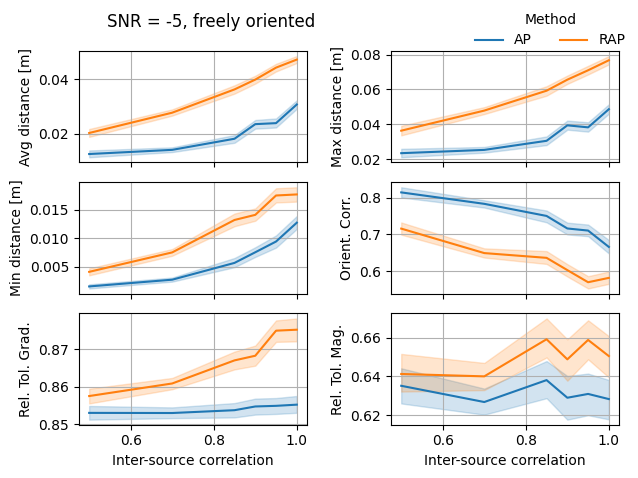

In [13]:
# SNR = -5
fig, ax = plot_line_by_attr_free_ori(
    tmp_corr_data, "SNR_bin", "Sig_corr_bin", -5, additional_info=additional_info)

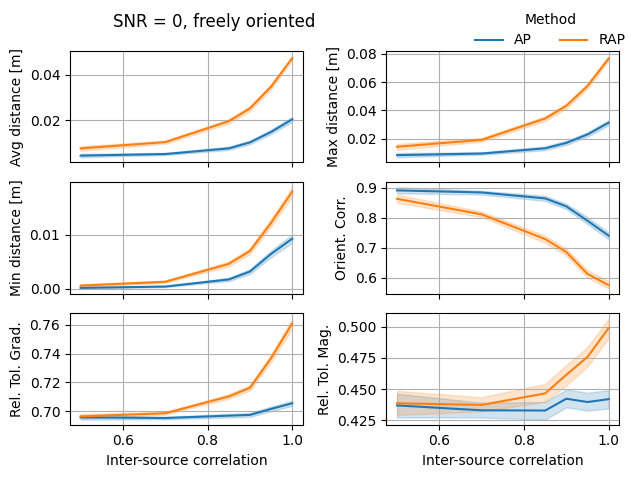

In [14]:
# SNR = 0
fig, ax = plot_line_by_attr_free_ori(
    tmp_corr_data, "SNR_bin", "Sig_corr_bin", 0, additional_info=additional_info)

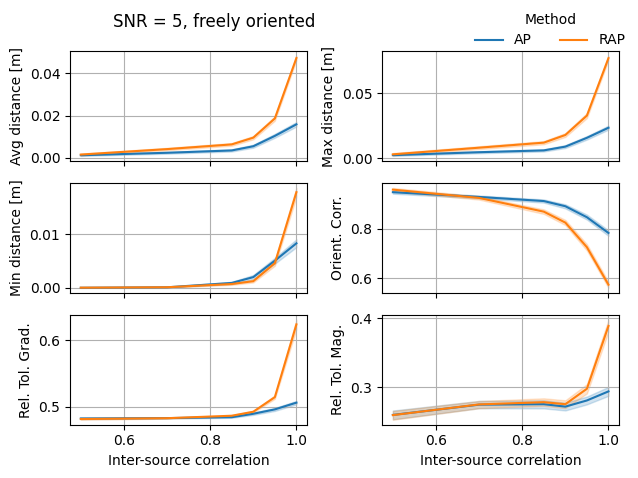

In [15]:
# SNR = 5
fig, ax = plot_line_by_attr_free_ori(
    tmp_corr_data, "SNR_bin", "Sig_corr_bin", 5, additional_info=additional_info)

##### Visualizing for a fixed Inter-source correlation

In [16]:
additional_info = {
    'set_attr':'Inter-source correlation',
    'ori':'freely oriented',
    'xlabel':'SNR'
}

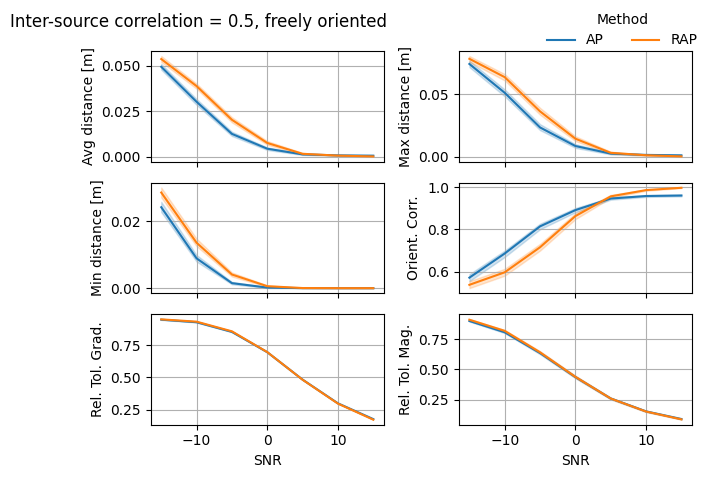

In [17]:
# Signal Correlation = 0.5
fig, ax = plot_line_by_attr_free_ori(
    tmp_corr_data, "Sig_corr_bin", "SNR_bin", 0.5, additional_info=additional_info)

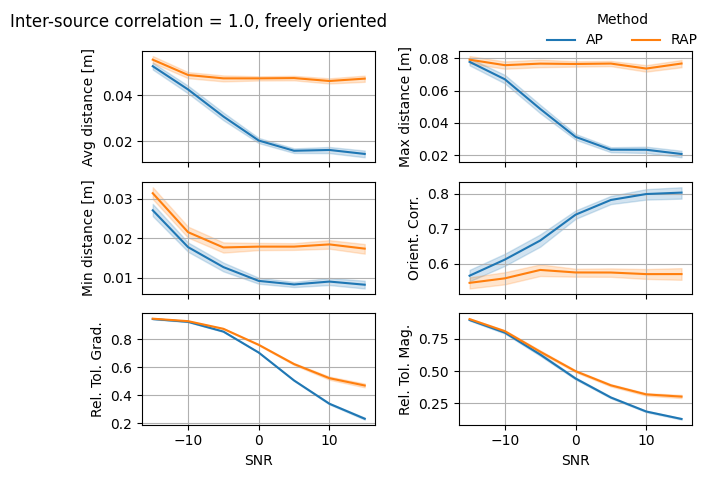

In [18]:
# Signal Correlation = 1.0
fig, ax = plot_line_by_attr_free_ori(
    tmp_corr_data, "Sig_corr_bin", "SNR_bin", 1.0, additional_info=additional_info)

##### Heatmap summary

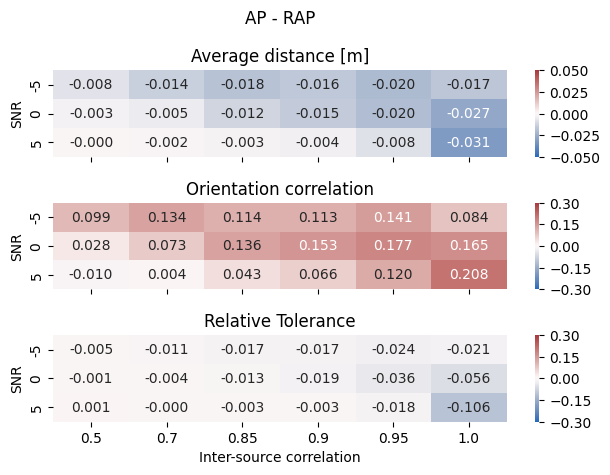

In [19]:
#heatmap difference : Alternating Projections - RAP MUSIC
fig, ax = plot_heatmap_diff_free_ori(ap_heatmap_prep, rap_heatmap_prep)

### Fixed oriented dipoles model

##### Loading and prepering the data set

In [20]:
# loading fixed oriented simulation data
save_path = "APvRAP_fixed.h5"
test_data_fixed = pd.read_hdf(save_path, 'test_data')
test_data_free.describe()

SNR      Sig_corr  Simulated_dis     Pos_err_1     Pos_err_2  \
count  6.754700e+04  67547.000000   67547.000000  67547.000000  67547.000000   
mean  -7.831584e-02      0.820517       0.085119      0.021649      0.023825   
std    9.158665e+00      0.159144       0.025336      0.030112      0.034668   
min   -1.500000e+01      0.480005       0.007377      0.000000      0.000000   
25%   -1.000000e+01      0.701570       0.067436      0.000000      0.000000   
50%    1.928655e-15      0.860073       0.086330      0.008129      0.000000   
75%    5.000000e+00      0.949867       0.103158      0.034557      0.035862   
max    1.500000e+01      1.000000       0.166555      0.162747      0.164200   

         Ori_corr_1    Ori_corr_2   rel_tol_mag  rel_tol_grad  
count  67547.000000  67547.000000  67547.000000  67547.000000  
mean       0.000813      0.070287      0.477779      0.650193  
std        0.802806      0.807210      0.286045      0.258582  
min       -1.000000     -1.000000      0.027581      0.154803  
25%       -0.887969     -0.846887      0.222706      0.477438  
50%        0.000612      0.200787      0.431749      0.700254  
75%        0.884159      0.929111      0.747835      0.897101  
max        1.000000      1.000000      1.235913      1.349485

In [21]:
sig_corr_seeds = [0.5,0.7,0.85,0.9,0.95,1]
snr_seeds = [-15,-10,-5,0,5,10,15]
tmp_corr_data, ap_heatmap_prep, rap_heatmap_prep = prep_data(test_data_fixed, sig_corr_seeds, snr_seeds)

##### Visualizing for a fixed SNR

In [22]:
additional_info = {
    'set_attr':'SNR',
    'ori':'fixed orientation',
    'xlabel':'Inter-source correlation'
}

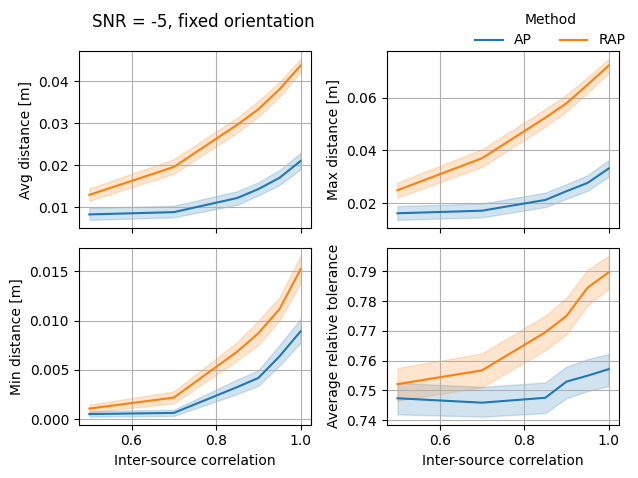

In [23]:
# SNR = -5
fig, ax = plot_line_by_attr_fixed_ori(
    tmp_corr_data, "SNR_bin", "Sig_corr_bin", -5, additional_info=additional_info)

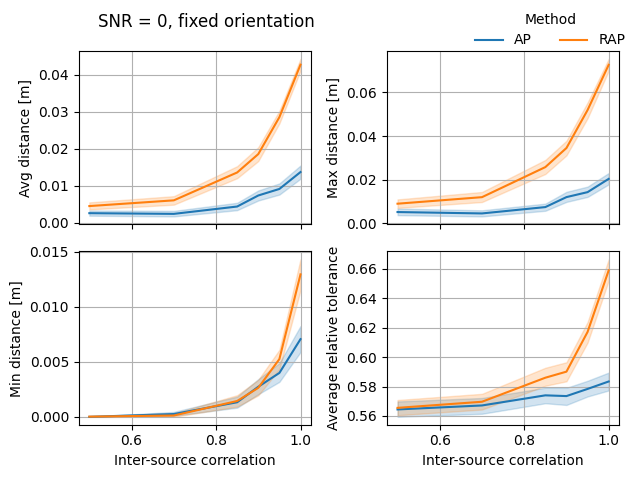

In [24]:
# SNR = 0
fig, ax = plot_line_by_attr_fixed_ori(
    tmp_corr_data, "SNR_bin", "Sig_corr_bin", 0, additional_info=additional_info)

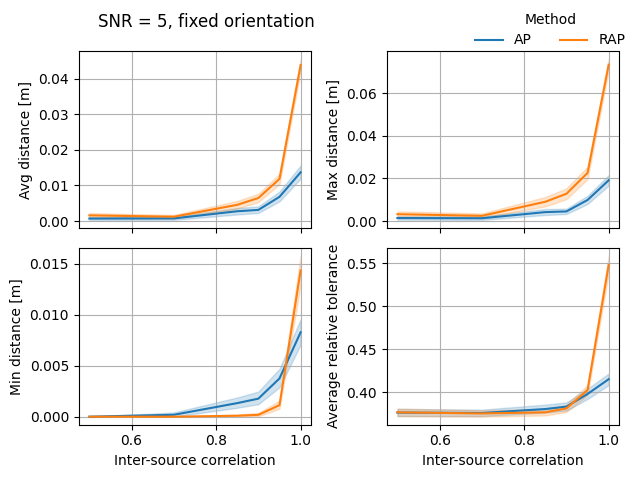

In [25]:
# SNR = 5
fig, ax = plot_line_by_attr_fixed_ori(
    tmp_corr_data, "SNR_bin", "Sig_corr_bin", 5, additional_info=additional_info)

##### Visualizing for a fixed Inter-source correlation

In [26]:
additional_info = {
    'set_attr':'Inter-source correlation',
    'ori':'fixed orientation',
    'xlabel':'SNR'
}

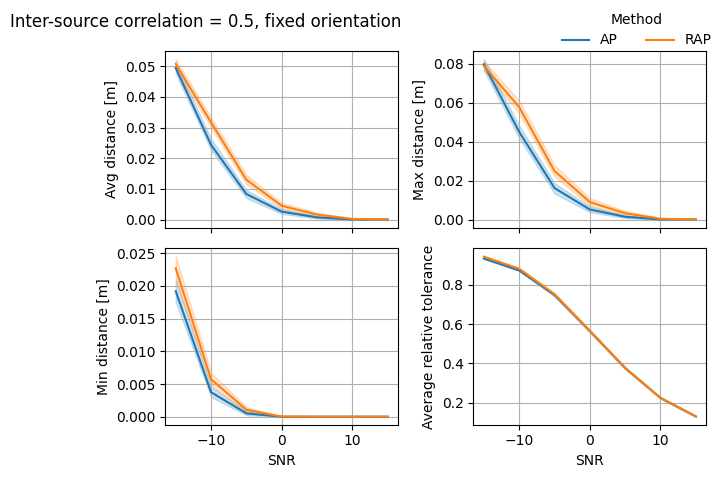

In [27]:
# Signal Correlation = 0.5
fig, ax = plot_line_by_attr_fixed_ori(
    tmp_corr_data, "Sig_corr_bin", "SNR_bin", 0.5, additional_info=additional_info)

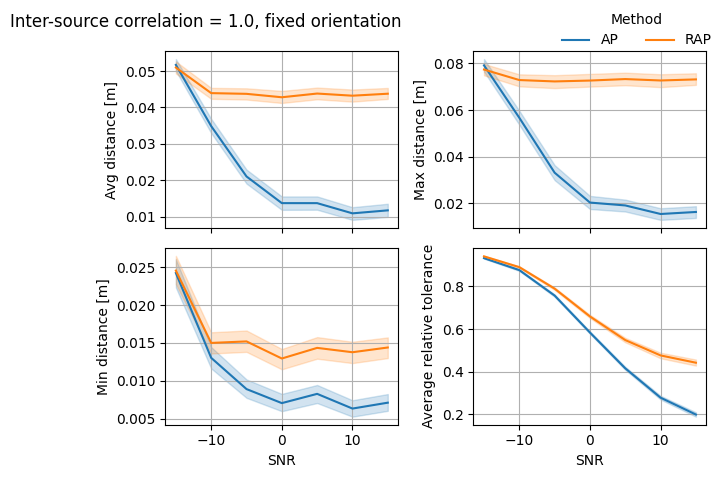

In [28]:
# Signal Correlation = 1.0
fig, ax = plot_line_by_attr_fixed_ori(
    tmp_corr_data, "Sig_corr_bin", "SNR_bin", 1.0, additional_info=additional_info)

##### Heatmap summary

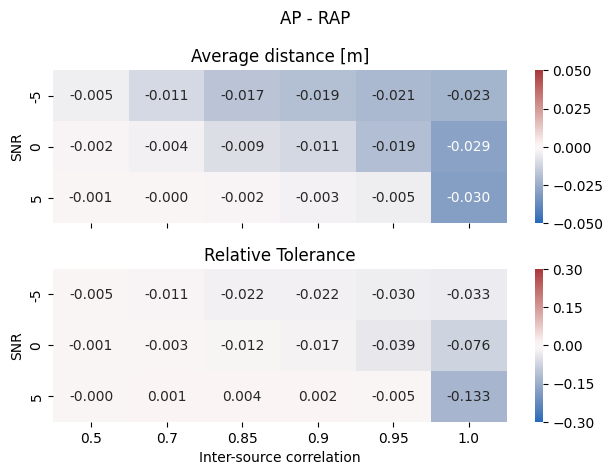

In [29]:
#heatmap difference : Alternating Projections - RAP MUSIC
fig, ax = plot_heatmap_diff_fixed_ori(ap_heatmap_prep, rap_heatmap_prep)

### Reproducing simulation data

In [30]:
data_path = testing.data_path(download=False)
fname_ave = op.join(data_path, 'MEG', 'sample', 'sample_audvis-ave.fif')
fname_cov = op.join(data_path, 'MEG', 'sample', 'sample_audvis-cov.fif')
fname_fwd = op.join(data_path, 'MEG', 'sample',
                    'sample_audvis_trunc-meg-eeg-oct-4-fwd.fif')

evoked, noise_cov = get_data(fname_ave, fname_cov, ch_decim=16)
fwd_free = mne.read_forward_solution(fname_fwd)
fwd_free = mne.pick_channels_forward(fwd_free, evoked.ch_names)
# forward_surf_ori = mne.convert_forward_solution(fwd_free, surf_ori=True)
fwd_fixed = mne.convert_forward_solution(fwd_free, force_fixed=True,surf_ori=True, use_cps=True)

Reading C:\Users\yuval\mne_data\MNE-testing-data\MEG\sample\sample_audvis-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Left Auditory)
        0 CTF compensation matrices available
        nave = 55 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>
    366 x 366 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    MAG regularization : 0.1
    GRAD regularization : 0.1
Reading forward solution from C:\Users\yuval\mne_data\MNE-testing-dat

example -  generating 2 randomized sources
( taken from aux_func.simu_data() ) 

<AxesSubplot: >

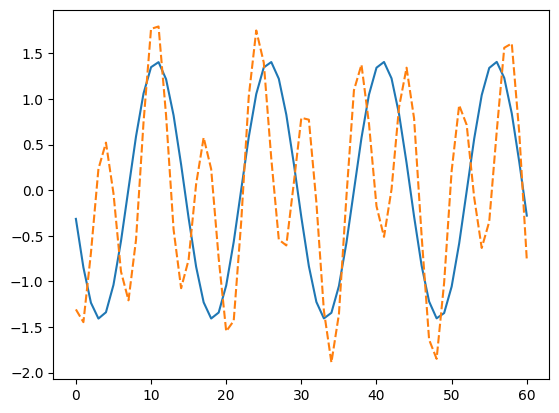

In [31]:
corr = 0.5
Q = 2
T = len(evoked.times)
min_t = np.min(evoked.times)
max_t = np.max(evoked.times)

while True:
    Y = gen_signals_correlated_cos(corr, Q, T, min_t, max_t)
    corr_test = np.abs((Y[0]/np.linalg.norm(Y[0]))@(Y[1].T/np.linalg.norm(Y[1])))
    if corr-0.02 < corr_test < corr+0.02:
        break

data = np.array([Y[0], Y[1]])
sns.lineplot(data.T, legend=False)

##### Simulating for freely-oriented dipoles model

In [ ]:
test_data_free = run_simulation(
    fwd_fixed, noise_cov, evoked, fwd_free = fwd_free, verbose = False)

##### Simulating for fixed-oriented dipoles model

In [ ]:
test_data_fixed = run_simulation(
    fwd_fixed, noise_cov, evoked, verbose = False)